<a href="https://colab.research.google.com/github/yweslakarep123/telkom_2019-2024/blob/main/telkom_2019_06_02_sampai_2024_06_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [11]:
file_path = '/content/drive/MyDrive/Test_dataset/data_telkom_2019-06-02_sampai_2024-06-02 - Sheet1.csv'
data = pd.read_csv(file_path)

In [12]:
data.head()

,Date,Open,High,Low,Close,Volume
0,10/06/2019 16:00:00,4000,4060,3970,4040,222522800
1,11/06/2019 16:00:00,4010,4060,4000,4020,88861700
2,12/06/2019 16:00:00,3880,3950,3840,3940,134724400
3,13/06/2019 16:00:00,3940,3990,3900,3990,115734700
4,14/06/2019 16:00:00,4020,4050,3970,3990,92466800


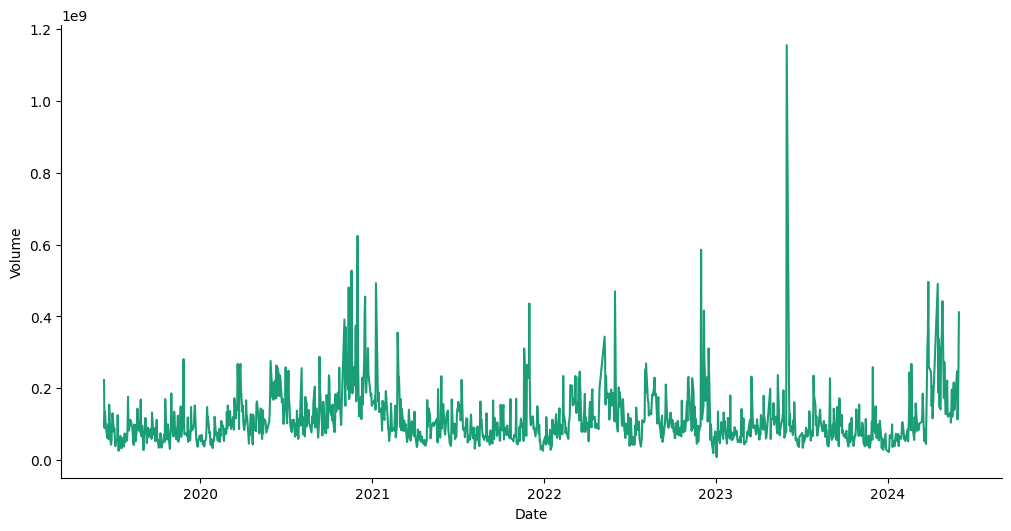

In [18]:
# @title Date vs Volume

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Volume']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Volume')

In [19]:
Minimum_High_category=data.loc[data['High'].idxmin()]
Minimum_High_category

Date      2020-11-03 16:00:00
Open                     2570
High                     2590
Low                      2540
Close                    2580
Volume              188874000
Name: 347, dtype: object

In [20]:
Maximum_High_category=data.loc[data['High'].idxmax()]
Maximum_High_category

Date      2022-04-28 16:00:00
Open                     4850
High                     4850
Low                      4620
Close                    4620
Volume              198484800
Name: 712, dtype: object

In [21]:
Minimum_Low_category=data.loc[data['Low'].idxmin()]
Minimum_Low_category

Date      2020-03-20 16:00:00
Open                     2660
High                     2990
Low                      2450
Close                    2880
Volume              267694700
Name: 200, dtype: object

In [22]:
Maximum_Low_category=data.loc[data['Low'].idxmax()]
Maximum_Low_category

Date      2022-04-27 16:00:00
Open                     4720
High                     4790
Low                      4720
Close                    4770
Volume              136485600
Name: 711, dtype: object

In [14]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

In [16]:
data = data.sort_values('Date')

In [23]:
close_prices = data['Close'].values.reshape(-1, 1)

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [36]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [37]:
seq_length = 60

In [38]:
X, y = create_sequences(scaled_data, seq_length)

In [39]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [40]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [41]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [42]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

920/920 [==============================] - 35s 33ms/step - loss: 0.0047


In [44]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 1s 17ms/step


In [45]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 8845.338075276564


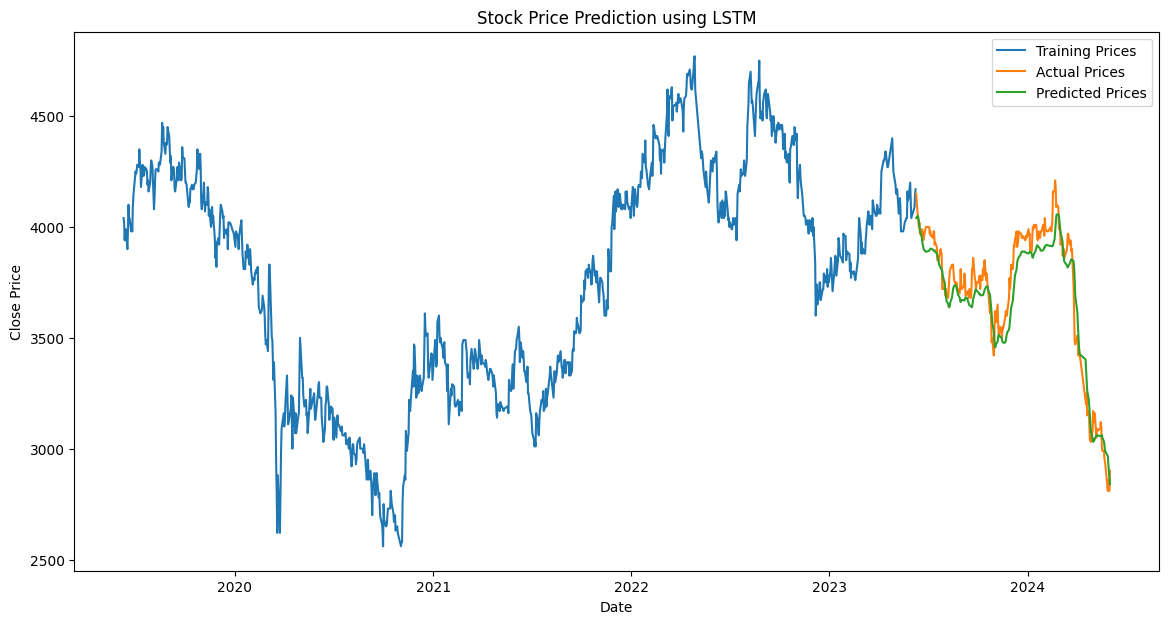

In [46]:
# Prepare the dataset for plotting
train = data[:split + seq_length]
valid = data[split + seq_length:]
valid = valid.copy()
valid['Predictions'] = predictions

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train['Date'], train['Close'], label='Training Prices')
plt.plot(valid['Date'], valid['Close'], label='Actual Prices')
plt.plot(valid['Date'], valid['Predictions'], label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()

In [47]:
model.save('/content/drive/MyDrive/test_model/lstm_stock_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 24ms/step


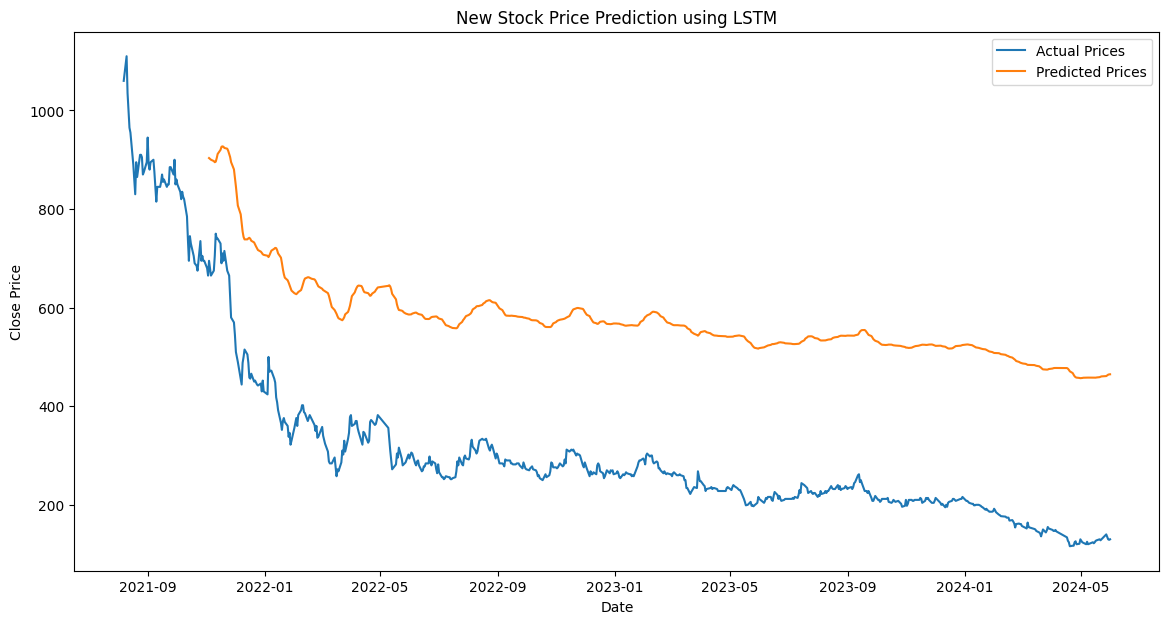

In [49]:
from keras.models import load_model

def predict_new_data(model_path, new_data_path, seq_length=60):
    # Load the saved model
    model = load_model(model_path)

    # Load new data
    new_data = pd.read_csv(new_data_path)
    new_data['Date'] = pd.to_datetime(new_data['Date'], dayfirst=True)
    new_data = new_data.sort_values('Date')

    # Preprocess the new data
    close_prices = new_data['Close'].values.reshape(-1, 1)
    scaled_data = scaler.transform(close_prices)

    # Create sequences from the new data
    X_new, _ = create_sequences(scaled_data, seq_length)
    X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))

    # Make predictions
    predictions = model.predict(X_new)
    predictions = scaler.inverse_transform(predictions)

    # Prepare the data for plotting
    valid = new_data[seq_length:].copy()
    valid['Predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(new_data['Date'], new_data['Close'], label='Actual Prices')
    plt.plot(valid['Date'], valid['Predictions'], label='Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('New Stock Price Prediction using LSTM')
    plt.legend()
    plt.show()

new_data = '/content/drive/MyDrive/Test_dataset/data_GOOGLEFIN_2019-06-02_sampai_2024-06-02 - bukalapak.csv'
model = '/content/drive/MyDrive/test_model/lstm_stock_model.h5'

predict_new_data(model, new_data)